### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [63]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# verbose = True   # print calculation output and weights and bias matrices 
verbose = False  # print calculation output only

In [65]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

In [66]:
def print_parameters(parameters):
  # number of parameters (e.g sum (weights + bias to each neuron and output))
  # MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
  # print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(parameters())}\n')
  print(f'Total parameters: {len(parameters())}\n')  

  # print first 5 parameters
  for i, v in enumerate(parameters()):
    if i < 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')
  
  print('---')

  # print last 5 parameters   
  for i, v in enumerate(parameters()):
    if i >= len(parameters()) - 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')

In [67]:
def get_wt_n_b_mats(layers, verbose=False):
  ''' Get neuron's weights and bias for each layer.
  Inputs: If n = MLP(2, [3, 3, 1]), input is n.layers.

  return: two lists of np.arrays. The first list is weight matrix for each layer
          The second list is the bias matrix for each layer 
  '''
  layer_cnt = len(layers)  # number of layers
  w_mats = []  # list of weights matrix for each layer 
  b_mats = []  # list of bias matrix for each layer
  if verbose:
    print(f'layer_cnt: {layer_cnt}\n')
  for i, layer in enumerate(layers):
      neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer
      if verbose: 
        print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

        print('----')
      b_mat = []  # accumulate neuon's bias for each row     
      for j, neuron in enumerate(layer.neurons):
          if verbose:
            print(f'layer: {i}, neuron {j}')
          b = neuron.b.data  # bias of neuron 
          w_row = []  # accumulate neuon's weights for each row
          b_row = []  # accumulate neuon's bias for each row
          for k, w in enumerate(neuron.w):
              w_row.append(w.data)
              if verbose:
                print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
          if j == 0:            
              w_mat = np.array([w_row])
          else:
              w_mat = np.vstack((w_mat, w_row))
          
          b_mat.append(b)
          if verbose:
            print(f'b:  {b:10.7f}\n')
            print(f'b:  {b:10.7f}')        
            print(f'b_mat:  {b_mat}\n')
      w_mats.append(w_mat)  
      b_mats.append(np.array([b_mat]))        
      if verbose:
          print('------')

  zipped_w_n_b = zip(w_mats, b_mats)
  if verbose:
    for i, w_n_b in enumerate(zipped_w_n_b):
      print(f'layer: {i}')  # 1st layer is 0    
      print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
      print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  

  return w_mats, b_mats

In [68]:
def forward_pass(layers, verbose=verbose):
  # Get Neural Network's Weights and Biases Matrices
  # w_mats, b_mats = get_wt_n_b_mats(n.layers, verbose=verbose)
  w_mats, b_mats = get_wt_n_b_mats(layers, verbose=verbose)

  # Calculate Neural Network Output and Loss with Matrix Multiplication
  for layer in range(len(layers)):
    if layer == 0:  # first layer, use given inputs xs as inputs
      input = xs_mats_T[layer]
    else:  # after first layer, use outputs from preceding layers as inputs
      input = output

    weights = w_mats[layer]
    bias = np.transpose(b_mats[layer])

    weights_x_input = np.matmul(weights, input)
    weights_x_input_plus_bias = weights_x_input + bias

    # output = np.tanh(np.matmul(weights, input) + bias)
    output = np.tanh(weights_x_input_plus_bias)

    print(f'{"-"*50}')
    print(f'Calculate Output of Layer: {layer}')    
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_+_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')    

    # print(f'output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    
    print(f'Layer {layer} Output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    

  yout = output[0]
  err_sq = ((yout - ys)**2)
  loss_sum = err_sq.sum()
  loss_mean = err_sq.mean()

  # print(f'-- Manual calculation results of neural network output and prediction error --')
  print(f'-- Results of neural network output and prediction error --')  
  print(f'yout:           {yout}')   
  print(f'desired output: {ys}')   
  print(f'err_sq:         {err_sq}')
  print(f'loss_mean:      {loss_mean}')
  print(f'loss_sum:       {loss_sum}')

  return yout, err_sq, loss_sum, loss_mean, w_mats, b_mats


### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [69]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [70]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [71]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

#   &nbsp;
# - Human Brain and Artificial Neural Network - 

### --- Neurons in Human Brain ---
![](..\karpathy\img\neuron_of_human_brain.png)

### --- Simple Artificial Neural Network ---<br>* input layer: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 nodes<br>* hidden layer 1: &nbsp;3 nodes<br>* hidden layer 2:&nbsp;&nbsp;3 nodes<br>*  output layer: &nbsp;&nbsp;&nbsp; 1 node<br>* node's bias and activation function are not shown

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### --- Artificial Neuron Function ---

<img src="..\karpathy\img\Artificial Neuron Function.png">

#   &nbsp;
# - Visualize Math Operations in a Hidden Layer -

### * Assume hidden layer with two inputs (X0, X1), and three neurons (b0, b1, b2)<br>* Two sets of inputs (X0, X1) are shown in different shades of gray<br>* Two sets of outputs (Y0, Y1, Y2) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

#   &nbsp;
# - How Artificial Neural Network Learns -

### --- Create Simple Neural Network ---

##### ----- Create Simple Neural Network MLP(2, [3, 3, 1]) -----<br>* 2 input nodes<br>* 3 neurons in hidden layer 1<br>* 3 neurons in hidden layer 2<br>* 1 output node
##### ----- Initialize Neurons Parameters -----<br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = &nbsp;&nbsp;&nbsp;&nbsp;  9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = &nbsp;&nbsp;&nbsp; 4<br>*  total parameters: 25

In [72]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# if verbose:
if True:
  print("Neuron parameters, initalized with random numbers")
  print_parameters(n.parameters)

Neuron parameters, initalized with random numbers
Total parameters: 25

i:  0,   0.6867520004
i:  1,  -0.2222184830
i:  2,   0.7987912217
i:  3,   0.2242820506
i:  4,   0.4690447835
---
i: 20,  -0.7466742802
i: 21,   0.6123266076
i: 22,  -0.4077078640
i: 23,   0.9893965494
i: 24,   0.3635939046


##### ----- Inputs -----<br>* 1st set: [2.0, 3.0]<br>* 2nd set: [3.0, -1.0]
##### ----- Desired Output -----<br>* [1.0, -1.0] for all input sets
##### ----- Learning Rate -----<br>* 0.05

In [73]:
# inputs
xs = [
  [2.0, 3.0],
  [3.0, -1.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [74]:
# if True:
if verbose:
	# print weights and bias of each layer
	for i, layer in enumerate(n.layers):
		neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer 
		print(f'layer: {i}, neuron_cnt: {neuron_cnt}, layer: {layer}')

### --- Manual Calculation of Neural Network Output and Prediction Error ---<br>* transpose inputs  <br>* calculate neural network output, (a.k.a) Forward Pass<br>* calculate prediction error, (a.k.a) Loss

##### ----- Transpose Inputs -----

In [75]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  3.],
       [ 3., -1.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 3., -1.]])]


##### ----- Common Activation Functions ----- 

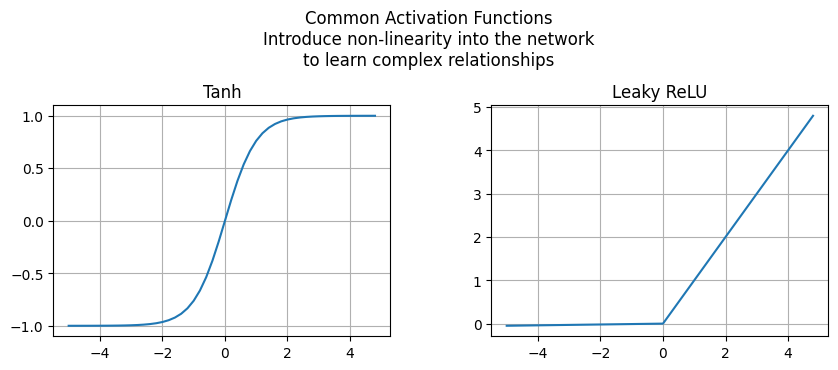

In [76]:
# Common Activation Functions
x = np.arange(-5, 5, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, np.tanh(x))
ax1.set_title("Tanh")
ax1.grid()

a = x[x < 0]*0.01
b = x[x >= 0]
y = np.concatenate((a, b))
ax2.grid()
ax2.plot(x, y)
ax2.set_title("Leaky ReLU")

plt_title = "Common Activation Functions\nIntroduce non-linearity into the network\nto learn complex relationships"
plt.suptitle(plt_title , fontsize=12, y=1.2)
plt.subplots_adjust(wspace=0.3)
plt.show()

##### ----- Calculate Outputs and Prediction Errors (a.k.a Loss) Using Tanh Activation ----- 

In [77]:
yout, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.686752   -0.22221848]
 [ 0.22428205  0.46904478]
 [-0.87367886 -0.79049592]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[ 0.70684855  2.28247448]
 [ 1.85569845  0.20380137]
 [-4.11884548 -1.83054067]]

bias (3, 1):
[[ 0.79879122]
 [-0.19982856]
 [ 0.18388279]]

weights_x_inputs_+_bias (3, 2):
[[ 1.50563977  3.08126571]
 [ 1.65586989  0.00397281]
 [-3.93496269 -1.64665789]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.90616221  0.99579503]
 [ 0.92965873  0.00397279]
 [-0.99923617 -0.92839758]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.26789621 -0.61339528 -0.3428927 ]
 [ 0.04994468  0.37149209  0.86449525]
 [ 0.36764975  0.38515815  0.75988496]]

input (3, 2):
[[ 0.90616221  0.99579503]
 [ 0.92965873  0.00397279]
 [-0.99923617 -0.92839758]]

weights_x_inputs (3, 2):
[[-0.47037491  0.04913415

In [119]:
print(f'-- Results of neural network output and prediction error --')
print(f'yout:           {yout} <-- neural network output')   
print(f'desired output: {ys}')   
print(f'err_sq:         {err_sq}')
print(f'loss_mean:      {loss_mean}')
print(f'loss_sum:       {loss_sum} <-- sum(prediction_error)^2')


-- Results of neural network output and prediction error --
yout:           [-0.5565309 -0.1584199] <-- neural network output
desired output: [1.0, -1.0]
err_sq:         [1.4351103154930065, 0.990802001310633]
loss_mean:      1.2129561584018198
loss_sum:       2.4259123168036396 <-- sum(prediction_error)^2


##### ---- End: Manual Calculation of Neural Network Output and Prediction Error ----

##### How Neural Network Learns<br>* calculate changes in prediction errors (loss) w.r.t. changes in each parameter (a.k.a. gradients)<br>* adjust parameters in direction of less loss with gradients<br>* repeat the process 

##### Calculate gradient for parameter W0<br>* increase W0 by small amount, e.g. 0.00001<br>* recalculate output and loss<br>* calculate changes in loss w.r.t. changes in W0

In [79]:
# Increase W1 by h
h = .00001
loss_sum_before = loss_sum
print(f'loss_sum_before:  {loss_sum_before:10.7f} <-- loss_sum before increase W1')
W0_before = n.parameters()[0].data  # W1
print(f'W0_before:        {W0_before:10.7f}')
n.parameters()[0].data += h
W0_after = n.parameters()[0].data
print(f'W0_after:         {W0_after:10.7f}') 
W0_dif = W0_after - W0_before
print(f'W0_dif:           {W0_dif:10.7f} <-- increased W1 by a small amount') 

loss_sum_before:   2.4259123 <-- loss_sum before increase W1
W0_before:         0.6867520
W0_after:          0.6867620
W0_dif:            0.0000100 <-- increased W1 by a small amount


##### Recalculate output and Loss with small changes in W0

In [80]:
yout, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.686762   -0.22221848]
 [ 0.22428205  0.46904478]
 [-0.87367886 -0.79049592]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[ 0.70686855  2.28250448]
 [ 1.85569845  0.20380137]
 [-4.11884548 -1.83054067]]

bias (3, 1):
[[ 0.79879122]
 [-0.19982856]
 [ 0.18388279]]

weights_x_inputs_+_bias (3, 2):
[[ 1.50565977  3.08129571]
 [ 1.65586989  0.00397281]
 [-3.93496269 -1.64665789]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.90616579  0.99579529]
 [ 0.92965873  0.00397279]
 [-0.99923617 -0.92839758]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.26789621 -0.61339528 -0.3428927 ]
 [ 0.04994468  0.37149209  0.86449525]
 [ 0.36764975  0.38515815  0.75988496]]

input (3, 2):
[[ 0.90616579  0.99579529]
 [ 0.92965873  0.00397279]
 [-0.99923617 -0.92839758]]

weights_x_inputs (3, 2):
[[-0.47037587  0.04913408

In [81]:
loss_sum_after = loss_sum
loss_sum_dif = loss_sum_after - loss_sum_before
W0_grad = loss_sum_dif / W0_dif

# print(f'-- manual forward pass calculation --')
print(f'-- recaluclate neural network output and loss with small change in W1 --')
print(f'yout:             {yout}')   
print(f'desired output:   {ys}')   
print(f'err_sq:           {err_sq}')
print(f'loss_sum_before:  {loss_sum_before}')
print(f'loss_sum_after:   {loss_sum_after}\n')
print(f'loss_sum_dif:     {loss_sum_dif} <-- change in loss_sum')
print(f'W0_dif:           {W0_dif} <-- change in W0')
print(f'W0_grad:          {W0_grad} <-- changes in loss_sum w.r.t. changes in W0, manual calculation')

-- recaluclate neural network output and loss with small change in W1 --
yout:             [-0.19796069 -0.00460963]
desired output:   [1.0, -1.0]
err_sq:           [1.43510981 0.99080199]
loss_sum_before:  2.425912316803639
loss_sum_after:   2.4259117921496927

loss_sum_dif:     -5.24653946509801e-07 <-- change in loss_sum
W0_dif:           9.99999999995449e-06 <-- change in W0
W0_grad:          -0.052465394651218876 <-- changes in loss_sum w.r.t. changes in W0, manual calculation


##### Calculate output and Loss with Micrograd<br>* change W1 back to initial value<br>* compare manual calculation vs Micrograd 

In [82]:
# change W1 back before Micrograd calculation
n.parameters()[0].data = W0_before

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
# loss.backward()
err_sq_ = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
err_sq = [l.data for l in err_sq_]
loss_sum = sum(err_sq)
loss_len = len(err_sq)
loss_mean = loss_sum / loss_len

# print(f'-- Micrograd forward pass and backward pass --')
print(f'-- Calculate neural network loss and gradient using Micrograd --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'err_sq:             {err_sq}')
print(f'loss_mean:          {loss_mean}')
print(f'loss_sum:           {loss_sum} <-- loss_sum, Micrograd calculation same as manual calc.')
print(f'W0_before:          {n.parameters()[0].data}')

-- Calculate neural network loss and gradient using Micrograd --
ypred_data:         [-0.19796089898335428, -0.004609623659826039]
ys:                 [1.0, -1.0]
err_sq:             [1.4351103154930065, 0.990802001310633]
loss_mean:          1.2129561584018198
loss_sum:           2.4259123168036396 <-- loss_sum, Micrograd calculation same as manual calc.
W0_before:          0.6867520003967265


##### Calculate gradients and adjust parameters

In [83]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
print('=== adjust parameters ===')
print(f'  i  parameter before         gradient     learning rate   parameter adjusted')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad

  if i == 0:  
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f} <-- gradient same as manual calc. W0_grad {W0_grad:13.10f}')
  else:
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')    

=== adjust parameters ===
  i  parameter before         gradient     learning rate   parameter adjusted
  0      0.6867520004    -0.0524661770           0.05000         0.6893753092 <-- gradient same as manual calc. W0_grad -0.0524653947
  1     -0.2222184830    -0.0757597597           0.05000        -0.2184304950
  2      0.7987912217    -0.0259658607           0.05000         0.8000895147
  3      0.2242820506    -1.4263130503           0.05000         0.2955977031
  4      0.4690447835     0.6210926415           0.05000         0.4379901514
  5     -0.1998285591    -0.4621963236           0.05000        -0.1767187429
  6     -0.8736788642     0.0197501976           0.05000        -0.8746663740
  7     -0.7904959179    -0.0087860380           0.05000        -0.7900566160
  8      0.1838827888     0.0063831593           0.05000         0.1835636308
  9     -0.2678962138     0.1697252729           0.05000        -0.2763824775
 10     -0.6133952816    -1.0621491164           0.05000    

### Improve Prediction with Parameter Iteration 

In [84]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = -0.05845852798520667), Value(data = 0.0036686888475327838)]
step: 0, loss: 2.127685292437536
-------
ypred: [Value(data = 0.03273087836208924), Value(data = 0.033962359898749094)]
step: 1, loss: 2.0046877153615656
-------
ypred: [Value(data = 0.07240410014364855), Value(data = 0.029835149125139435)]
step: 2, loss: 1.9209945878039125
-------
ypred: [Value(data = 0.10285572488171747), Value(data = 0.0072087041400784955)]
step: 3, loss: 1.819337224073045
-------
ypred: [Value(data = 0.14710871763837344), Value(data = -0.02952223825633276)]
step: 4, loss: 1.6692506255674582
-------
ypred: [Value(data = 0.21607197123859184), Value(data = -0.08853562480328475)]
step: 5, loss: 1.4453104615304857
-------
ypred: [Value(data = 0.31381588102820196), Value(data = -0.17415690309510243)]
step: 6, loss: 1.1528654658345747
-------
ypred: [Value(data = 0.42392184525226245), Value(data = -0.2765927697721152)]
step: 7, loss: 0.8551840611235382
-------
ypred: [Value(data = 0.517628403

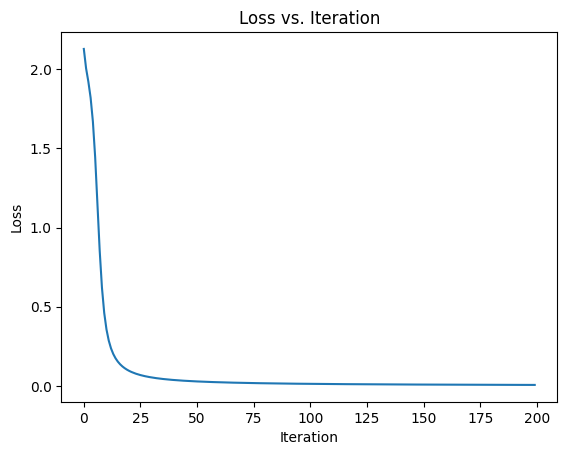

In [85]:
plot_losses(losses)

### Build same model with pyTorch 

In [86]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.1250122785568237
Epoch 10 loss: 0.7393882274627686
Epoch 20 loss: 0.12103889882564545
Epoch 30 loss: 0.004203637130558491

Prediction:
tensor([[ 0.9866],
        [-0.9937]])
Loss: 0.00015762122347950935


In [87]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.1428265571594238
Epoch 10 loss: 0.3982775807380676
Epoch 20 loss: 0.012284936383366585
Epoch 30 loss: 0.0001467839174438268

Prediction:
tensor([[ 0.9993],
        [-0.9983]])
Loss: 2.5899582851707237e-06


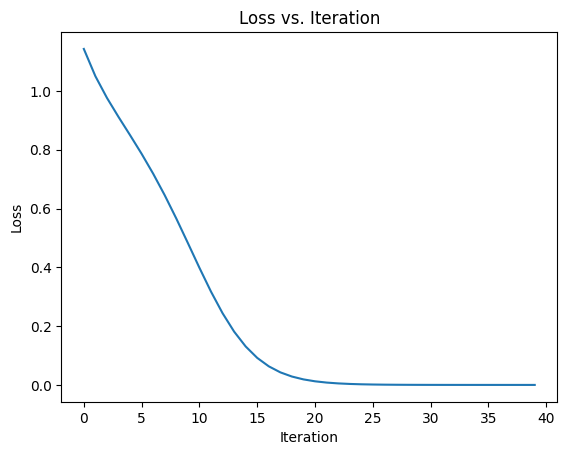

In [88]:
plot_losses(losses)

In [89]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.3158,  0.4424, -0.4478],
        [-0.2534, -0.4290,  0.0180],
        [ 0.3027, -0.2991,  0.1255],
        [-0.2813,  0.6195,  0.3644]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[ 1.1432, -1.6138],
        [-1.8118, -0.3222],
        [-0.4176,  1.2699],
        [ 0.9315, -1.2813]])

bT,  torch.Size([4, 1]):
tensor([[-0.3409],
        [-0.3853],
        [-0.0461],
        [ 0.2919]])

w * input + bT,  torch.Size([4, 2]):
tensor([[ 0.8023, -1.9547],
        [-2.1971, -0.7075],
        [-0.4638,  1.2237],
        [ 1.2234, -0.9894]])

output,  torch.Size([4, 2]):
tensor([[ 0.6653, -0.9607],
        [-0.9756, -0.6091],
        [-0.4332,  0.8407],
        [ 0.8406, -0.7571]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.3965,  0.002

In [90]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [91]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9993, -0.9983]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(1.6535e-06)

In [92]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9993, -0.9983]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0007,  0.0017]])
squared_difference: tensor([[4.6414e-07, 2.8429e-06]])


tensor(1.6535e-06)

In [93]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9993187189102173, -0.9983139038085938]

In [94]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

1.6535321449850926e-06


In [95]:
len(squared_difference)


1

In [96]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(1.6535e-06)

In [97]:
torch.sum((output - torch.tensor(ys))**2)


tensor(3.3071e-06)

##### Check Output and Gradient Calculation with PyTorch

In [98]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [99]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [100]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,  -0.0302291231
i:  1,   0.3076332282
i:  2,  -0.7196756558
i:  3,  -0.8960531292
i:  4,   0.1967775765
---
i: 36,   0.3565340805
i: 37,  -0.3849823637
i: 38,   0.1721548776
i: 39,   0.0004727207
i: 40,  -0.4347977994


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [101]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [102]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0: -0.0302291,   w0.grad:  0.0000000
w1:  0.3076332,   w1.grad:  0.0000000
w2: -0.7196757,   w2.grad:  0.0000000
b:  -0.8960531

layer: 0, neuron 1
w0:  0.1967776,   w0.grad:  0.0000000
w1:  0.9101712,   w1.grad:  0.0000000
w2:  0.5672971,   w2.grad:  0.0000000
b:   0.8468235

layer: 0, neuron 2
w0: -0.6811156,   w0.grad:  0.0000000
w1:  0.7112586,   w1.grad:  0.0000000
w2:  0.5230183,   w2.grad:  0.0000000
b:   0.8092413

layer: 0, neuron 3
w0: -0.2972417,   w0.grad:  0.0000000
w1:  0.4575358,   w1.grad:  0.0000000
w2:  0.4764906,   w2.grad:  0.0000000
b:  -0.0221654

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0: -0.0499433,   w0.grad:  0.0000000
w1: -0.6731243,   w1.grad:  0.0000000
w2: -0.3187645,   w2.grad:  0.0000000
w3:  0.5743313,   w3.grad:  0.0000000
b:  -0.1604849

layer: 1, neuron 1
w0: -0.0100580,   w0.grad:  0.0000000
w1: -0.9879730,   w1.grad:  0.0000000
w2:  0.7855079,   w2.grad:  0.0000000
w3: -

##### Print Neural Network's Weights and Biases Matrices

In [103]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[-0.03022912  0.30763323 -0.71967566]
 [ 0.19677758  0.91017122  0.56729713]
 [-0.68111559  0.71125857  0.52301831]
 [-0.29724169  0.45753576  0.4764906 ]]
b_mat(1, 4):
[[-0.89605313  0.84682351  0.80924129 -0.02216536]]

i: 1
w_mat(4, 4):
[[-0.04994329 -0.67312428 -0.31876452  0.57433134]
 [-0.01005801 -0.98797304  0.78550787 -0.08878883]
 [-0.63351206 -0.00171751 -0.42064243 -0.64686131]
 [ 0.050818   -0.71473076 -0.55840989 -0.74573099]]
b_mat(1, 4):
[[-0.16048487  0.0009477   0.42785253 -0.72395666]]

i: 2
w_mat(1, 4):
[[ 0.35653408 -0.38498236  0.17215488  0.00047272]]
b_mat(1, 1):
[[-0.4347978]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [104]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[-0.03022912  0.30763323 -0.71967566]
 [ 0.19677758  0.91017122  0.56729713]
 [-0.68111559  0.71125857  0.52301831]
 [-0.29724169  0.45753576  0.4764906 ]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[ 1.58211709 -0.75815843]
 [ 2.55677169 -0.03618993]
 [ 0.24852622 -2.49309619]
 [ 0.30163329 -1.11101552]]

bias (4, 1):
[[-0.89605313]
 [ 0.84682351]
 [ 0.80924129]
 [-0.02216536]]

weights_x_inputs_plus_bias (4, 2):
[[ 0.68606397 -1.65421155]
 [ 3.4035952   0.81063358]
 [ 1.05776751 -1.6838549 ]
 [ 0.27946793 -1.13318088]]

output (4, 2):
[[ 0.59544747 -0.92943329]
 [ 0.99779085  0.66993962]
 [ 0.78480791 -0.93336001]
 [ 0.27241257 -0.81210511]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[-0.04994329 -0.67312428 -0.31876452  0.57433134]
 [-0.01005801 -0.98797304  0.78550787 -0.08878883]
 [-0.63351206 -0.00171751 -0.42064243 -0.64686131]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [105]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [-0.5565308991729058, -0.15841990110024898]
ys:                 [1.0, -1.0]
loss_data:          3.1310455029441293


#### Micrograd backward pass and update parameters

In [106]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.0302291231     0.2476242664           0.05000        -0.0426103364
  1      0.3076332282     0.3942911534           0.05000         0.2879186706
  2     -0.7196756558    -0.1321229528           0.05000        -0.7130695082
  3     -0.8960531292     0.1258898381           0.05000        -0.9023476211
  4      0.1967775765    -0.1415994596           0.05000         0.2038575495
  5      0.9101712224     0.0396265697           0.05000         0.9081898939
  6      0.5672971315    -0.0208460008           0.05000         0.5683394315
  7      0.8468235066    -0.0478882972           0.05000         0.8492179215
  8     -0.6811155921     0.5134311729           0.05000        -0.7067871507
  9      0.7112585734     0.9462318559           0.05000         0.6639469806
 10      0.5230183149    -0.3207465307           0.05000         0.5390556415
 11      0.8092412896     0.2727233225

### Improve Prediction with Parameter Iteration 

In [107]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = -0.36030392429693975), Value(data = -0.2603916062057233)]
step: 0, loss: 2.397447342628604
-------
ypred: [Value(data = -0.0860356931343745), Value(data = -0.2855835392591673)]
step: 1, loss: 1.6898644061393189
-------
ypred: [Value(data = 0.18676196454390911), Value(data = -0.3288047347325327)]
step: 2, loss: 1.1118591864299479
-------
ypred: [Value(data = 0.3686713106307436), Value(data = -0.42718084535256473)]
step: 3, loss: 0.7266976979517055
-------
ypred: [Value(data = 0.48792118927470385), Value(data = -0.5305950113375449)]
step: 4, loss: 0.48256575177503325
-------
ypred: [Value(data = 0.5716655566650762), Value(data = -0.6117125138274834)]
step: 5, loss: 0.3342375672652113
-------
ypred: [Value(data = 0.631782393669811), Value(data = -0.6711914455085126)]
step: 6, loss: 0.24369927111831544
-------
ypred: [Value(data = 0.6760679148771108), Value(data = -0.7150306569061998)]
step: 7, loss: 0.18613952227537472
-------
ypred: [Value(data = 0.7097042783709064),

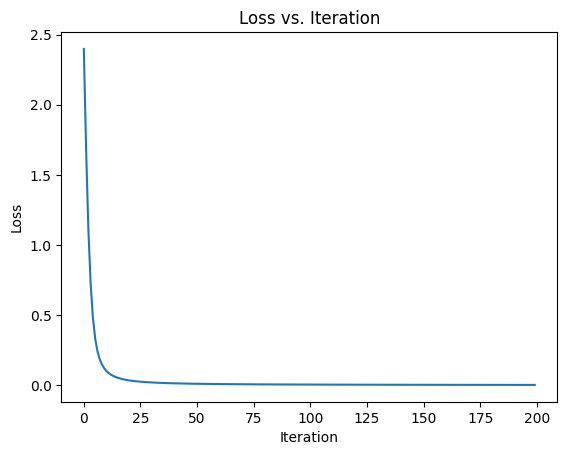

In [108]:
plot_losses(losses)

### Build same model with pyTorch 

In [109]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.077516794204712
Epoch 10 loss: 0.22936245799064636
Epoch 20 loss: 0.004696511197835207
Epoch 30 loss: 5.447819785331376e-05

Prediction:
tensor([[ 0.9998],
        [-0.9989]])
Loss: 9.76667024588096e-07


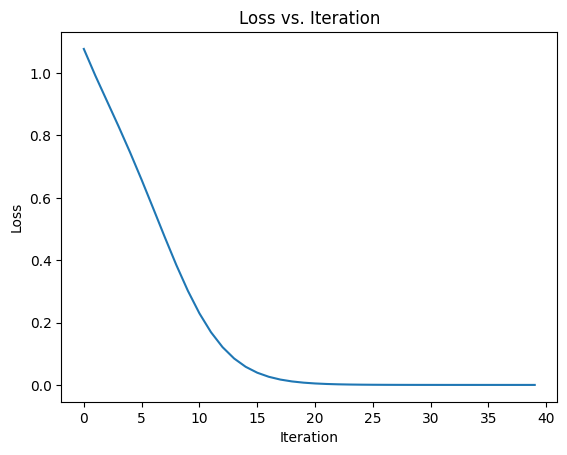

In [110]:
plot_losses(losses)

In [111]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.5211,  0.3833,  0.3718],
        [-0.4186,  0.6784,  0.2850],
        [ 0.4609, -0.3680, -0.2633],
        [-0.2246, -0.3473,  0.3522]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-0.2642, -1.7606],
        [ 0.9130, -1.7917],
        [ 0.0810,  1.6190],
        [-1.8432, -0.1506]])

bT,  torch.Size([4, 1]):
tensor([[ 0.2610],
        [ 0.0115],
        [-0.4900],
        [ 0.2559]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-0.0032, -1.4996],
        [ 0.9246, -1.7801],
        [-0.4090,  1.1290],
        [-1.5873,  0.1053]])

output,  torch.Size([4, 2]):
tensor([[-0.0032, -0.9051],
        [ 0.7281, -0.9447],
        [-0.3876,  0.8107],
        [-0.9197,  0.1049]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[ 0.1557, -0.036

In [112]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [113]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9998, -0.9989]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(1.2500e-06)

In [114]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9998, -0.9989]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0002,  0.0011]])
squared_difference: tensor([[6.0774e-08, 1.1892e-06]])


tensor(6.2501e-07)

In [115]:
difference
len(squared_difference)

1

In [116]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(6.2501e-07)

In [117]:
torch.sum((output - torch.tensor(ys))**2)

tensor(1.2500e-06)